In [11]:
import torch 
import pandas as pd 
import torch.nn as nn 
from torch.utils.data import random_split, DataLoader, TensorDataset 
import torch.nn.functional as F 
import numpy as np 
import torch.optim as optim 
from torch.optim import AdamW
import random
import matplotlib.pyplot as plt
import seaborn as sns

import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'


In [12]:
a = np.array([(i,j,i*j) for i in range(1,100) for j in range(1,100)])
a = np.log(a)
X = a[:, 0:2]
y = a[:,2]
y = y.reshape(-1,1)
y

array([[0.        ],
       [0.69314718],
       [1.09861229],
       ...,
       [9.16983083],
       [9.18008733],
       [9.1902397 ]])

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)



In [14]:

X_train = torch.Tensor(X_train) 
y_train = torch.Tensor(y_train)
X_val = torch.Tensor(X_val)
y_val = torch.Tensor(y_val)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)

train_set = TensorDataset(X_train, y_train) 
validate_set = TensorDataset(X_val, y_val) 
test_set = TensorDataset(X_test, y_test) 


# Create Dataloader to read the data within batch sizes and put into memory. 
train_loader = DataLoader(train_set, batch_size = 20, shuffle = True) 
validate_loader = DataLoader(validate_set, batch_size = 10) 
test_loader = DataLoader(test_set, batch_size = 1)

In [15]:
train_dataset_array = next(iter(train_loader))[0].numpy()
train_dataset_array 

array([[3.8918202, 3.8286414],
       [0.6931472, 3.0910425],
       [3.4339871, 0.6931472],
       [4.158883 , 3.988984 ],
       [3.2580965, 3.4339871],
       [4.5217886, 4.0253515],
       [4.564348 , 4.158883 ],
       [4.406719 , 2.7080503],
       [4.0943446, 1.0986123],
       [2.944439 , 4.276666 ],
       [4.5849676, 4.0073333],
       [3.637586 , 2.9957323],
       [1.7917595, 4.553877 ],
       [4.0430512, 3.8918202],
       [4.5325994, 3.9318256],
       [4.564348 , 4.2341065],
       [4.0775375, 4.465908 ],
       [4.317488 , 4.394449 ],
       [4.189655 , 4.4998097],
       [1.3862944, 4.465908 ]], dtype=float32)

In [16]:
# Define model parameters 


# Define neural network 
class Network(nn.Module): 
    def __init__(self, input_size, output_size, init_form="normal"): 
        super().__init__() 
        self.conv_stack = nn.Sequential(
        nn.Linear(input_size, 50), 
        nn.Dropout(p=0.1),
        nn.Tanh(),
        nn.Linear(50, 50),
        nn.Dropout(p=0.1),
        nn.Tanh(),
        nn.Linear(50, output_size))
        
                

        
        self.init_form = init_form
        if self.init_form is not None:
            self.init()

    def forward(self, x): 
        s = self.conv_stack(x)
        return s
    
    
        # xavier weight initialization
    def init(self):
        sigmoid_gain = torch.nn.init.calculate_gain("tanh")
        for child in self.conv_stack.children():
            if isinstance(child, nn.Linear):
                if self.init_form == "normal":
                    torch.nn.init.xavier_normal_(child.weight,
                                                 gain=sigmoid_gain)
                    if child.bias is not None:
                        torch.nn.init.zeros_(child.bias)
                elif self.init_form == "uniform":
                    torch.nn.init.xavier_uniform_(child.weight,
                                                  gain=sigmoid_gain)
                    if child.bias is not None:
                        torch.nn.init.zeros_(child.bias)
                else:
                    raise NotImplementedError()

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_epoch(model,
                optimizer,
                criterion,
                train_loader):
    loss_history = []
    for batch in train_loader: 
        optimizer.zero_grad()
        x_train, y_train = batch # parse data
        x_train, y_train = x_train.to(device), y_train.to(device) # compute on gpu
        y_pred = model(x_train) # get predictions
        loss = criterion(y_pred, y_train) # compute loss
        loss_history.append(loss.cpu().detach().numpy()) # write loss to log
        loss.backward()
        optimizer.step()
    return loss_history

In [18]:
def validate(model,
             criterion,
             val_loader):
    cumloss = 0
    loss_history = []
    with torch.no_grad():
        for batch in val_loader:
            x_train, y_train = batch # parse data
            x_train, y_train = x_train.to(device), y_train.to(device) # compute on gpu
            y_pred = model(x_train) # get predictions
            loss = criterion(y_pred, y_train) # compute loss
            loss_history.append(loss.cpu().detach().numpy()) # write loss to log
            cumloss += loss
    return cumloss / len(val_loader), loss_history # mean loss and history

In [19]:
from tqdm import tqdm

def train_model(model, optimizer, model_name=None, n_epochs=5):
  
    criterion = nn.MSELoss().to(device)

    train_history = {}
    train_history['model_name'] = model_name
    train_history['loss_on_train'] = []
    train_history['loss_on_test'] = []

    for epoch in tqdm(range(n_epochs)):
        loss_on_train = train_epoch(model,
                                    optimizer,
                                    criterion,
                                    train_loader)
        _, loss_on_test = validate(model,
                                   criterion,
                                   validate_loader)
        train_history['loss_on_train'].append(np.mean(loss_on_train))
        train_history['loss_on_test'].append(np.mean(loss_on_test))
        scheduler.step()
    return train_history

In [20]:
def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True


set_random_seed(42)

model = Network(2,1).to(device) 
optimizer = optim.AdamW(model.parameters(), lr=0.001)

lambda1 = lambda epoch: 0.998 ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1, last_epoch = -1)

n_epochs = 300
history = train_model(model, optimizer, model_name='model', n_epochs=n_epochs)


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [02:10<00:00,  2.30it/s]


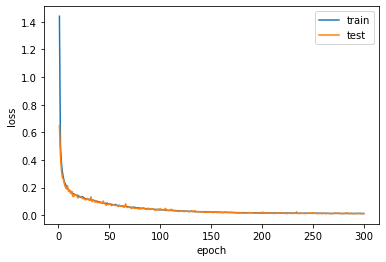

In [21]:
plt.plot(range(1,n_epochs+1), (history['loss_on_train']), label='train')
plt.plot(range(1,n_epochs+1), (history['loss_on_test']), label='test')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

In [22]:
model.eval()

Network(
  (conv_stack): Sequential(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Dropout(p=0.1, inplace=False)
    (2): Tanh()
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Dropout(p=0.1, inplace=False)
    (5): Tanh()
    (6): Linear(in_features=50, out_features=1, bias=True)
  )
)

In [23]:

def test(model, val_loader):
    cumloss1 = 0
    with torch.no_grad():
        for batch in val_loader:
            x_train, y_train = batch # parse data
            x_train, y_train = x_train.to(device), y_train.to(device) # compute on gpu
            y_pred = model(x_train) # get predictions
            loss1 = np.abs(np.exp(y_train) - np.exp(y_pred))/np.exp(y_train) # compute loss
            cumloss1 += loss1
    return cumloss1 / len(val_loader)


l = test(model, test_loader)
print('acc for NN =', l)

acc for NN = tensor([[0.0115]])


In [24]:
from scipy.special import jv
X1 = np.log(np.array([[10,2]]))




input1 = torch.Tensor(X1) 
a1 = (model(input1.to(device))).cpu().detach().numpy()
np.exp(a1)

array([[21.048304]], dtype=float32)